# ML Web App Using Flask Explore

# 1. Preparar el entorno. 

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
import joblib

# 2. Carga de Datos. 

In [7]:
df = pd.read_csv('../data/raw/data_starts.csv')
df.head()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Spectral Class
0,3068,0.002400,0.1700,16.12,0,Red,M
1,3042,0.000500,0.1542,16.60,0,Red,M
2,2600,0.000300,0.1020,18.70,0,Red,M
3,2800,0.000200,0.1600,16.65,0,Red,M
4,1939,0.000138,0.1030,20.06,0,Red,M


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    int64  
 5   Star color              240 non-null    object 
 6   Spectral Class          240 non-null    object 
dtypes: float64(3), int64(2), object(2)
memory usage: 13.2+ KB


In [9]:
df.columns

Index(['Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)',
       'Absolute magnitude(Mv)', 'Star type', 'Star color', 'Spectral Class'],
      dtype='object')

Notas:  
- No hay valores nulos. 
- Hay dos variables de tipo object "Star color" y "Spectral Class". 

In [10]:
df.describe()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type
count,240.000000,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107188.361635,237.157781,4.382396,2.500000
std,9552.425037,179432.244940,517.155763,10.532512,1.711394
min,1939.000000,0.000080,0.008400,-11.920000,0.000000
25%,3344.250000,0.000865,0.102750,-6.232500,1.000000
50%,5776.000000,0.070500,0.762500,8.313000,2.500000
75%,15055.500000,198050.000000,42.750000,13.697500,4.000000
max,40000.000000,849420.000000,1948.500000,20.060000,5.000000


# 3. EDA inicial. 

### Análisis univariado. 

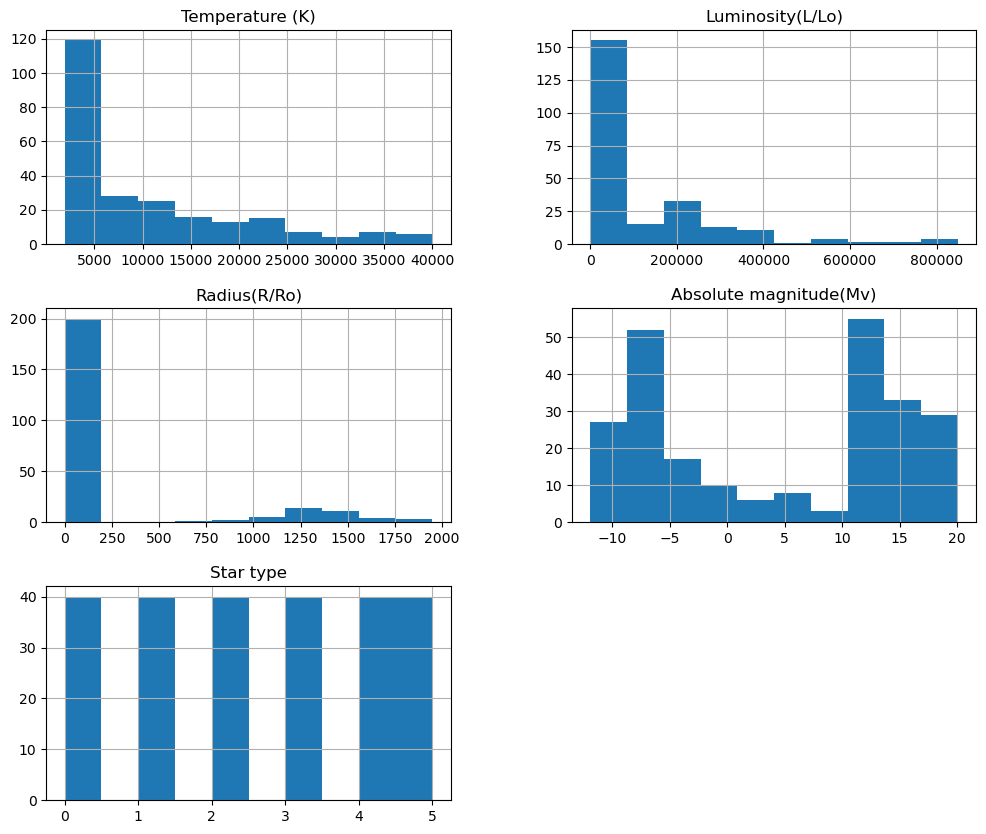

In [11]:
df.hist(figsize=(12,10))
plt.show()

### Análisis Bivariado. 

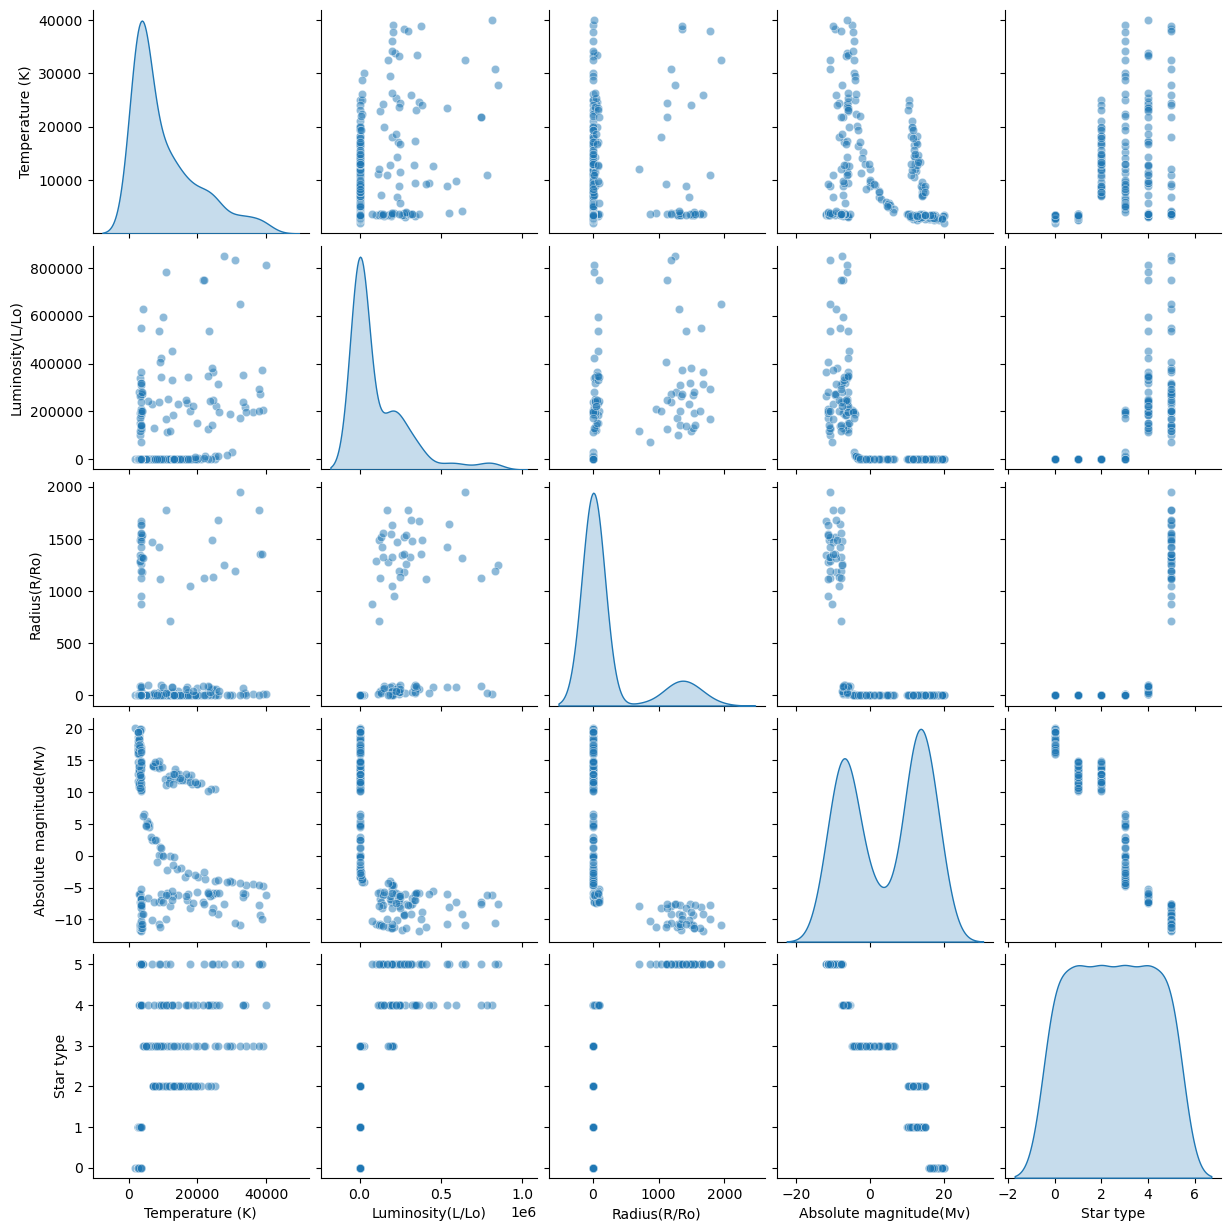

In [12]:
sns.pairplot(df, diag_kind='kde', markers='o', plot_kws={'alpha': 0.5})

### Correlación. 

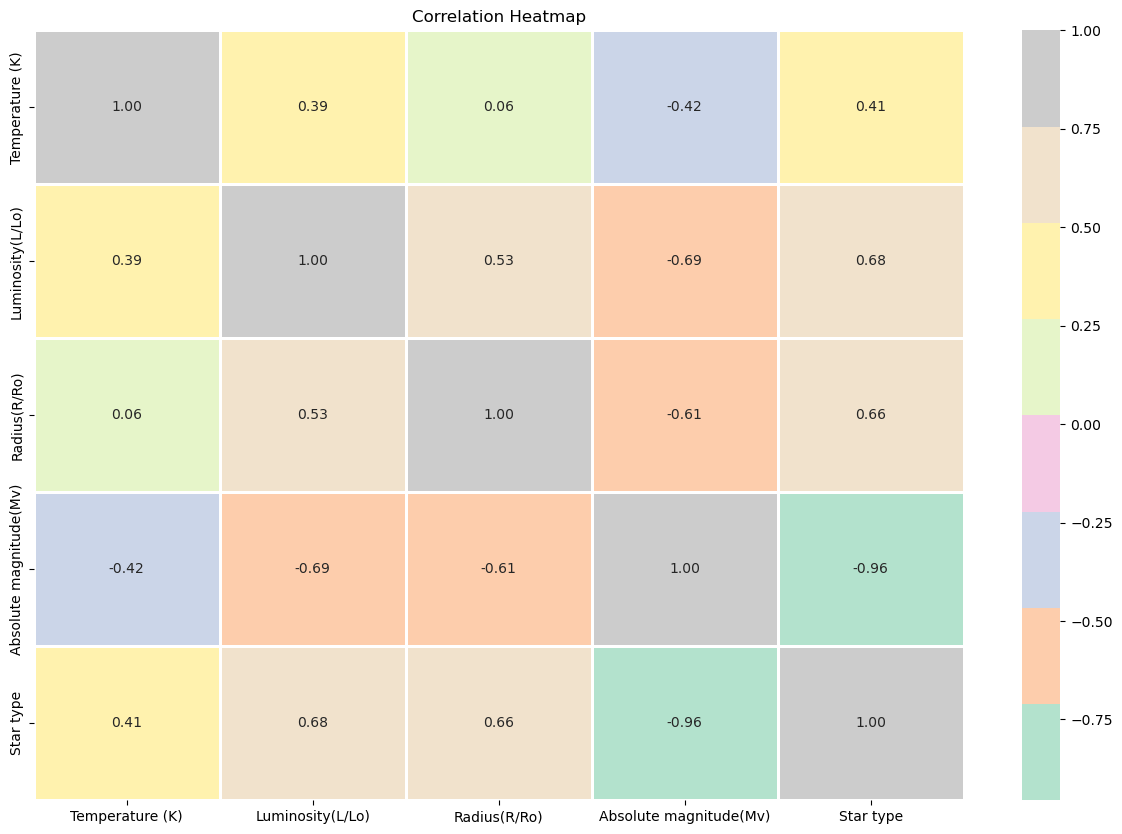

In [13]:
plt.figure(figsize=(15, 10))
df_numeric = df.drop(columns=['Star color', 'Spectral Class'])
sns.heatmap(df_numeric.corr(), annot=True, fmt='.2f', cmap='Pastel2', linewidths=2)

plt.title('Correlation Heatmap')
plt.show()

# 3. Limpieza de Datos (Data Cleansing). 

### Tratamiento de outliers. 

In [14]:
def outliers_column(df):
    columnas_con_outliers = []
    
    # Iterar sobre cada columna del DataFrame
    for col in df.columns:
        # Asegurarse de que la columna es numérica
        if pd.api.types.is_numeric_dtype(df[col]):
            q1 = df[col].quantile(0.25)
            q3 = df[col].quantile(0.75)
            iqr = q3 - q1
            
            # Definir los límites para los outliers
            limite_inferior = q1 - 1.5 * iqr
            limite_superior = q3 + 1.5 * iqr
            
            # Verificar si hay algún valor atípico en la columna
            outliers_presentes = ((df[col] < limite_inferior) | (df[col] > limite_superior)).any()
            
            # Si se encuentran outliers, agregar el nombre de la columna a la lista
            if outliers_presentes:
                columnas_con_outliers.append(col)
    
    return columnas_con_outliers

In [15]:
out_data = outliers_column(df)

In [16]:
def plot_outliers_boxplots(all_data, columns):
    # 1. Contar el número de columnas con outliers
    num_cols = len(columns)

    # 2. Definir la disposición de los subplots (ej. 2 filas, 2 columnas)
    # Esto es flexible, puedes ajustarlo según tus necesidades
    num_filas = 4
    num_columnas = int(np.ceil(num_cols / num_filas))

    # 3. Crear la figura y los subplots
    fig, axes = plt.subplots(num_filas, num_columnas, figsize=(15, 10))

    # Aplanar el array de ejes para iterar fácilmente
    axes = axes.flatten()

    # 4. Iterar sobre las columnas y dibujar el box plot en cada subplot
    for i, col in enumerate(columns):
        ax = axes[i]
        ax.boxplot(all_data[col], vert=False) # vert=False para que sean horizontales
        ax.set_title(f'{col}')
        ax.set_xlabel('Valores')
        ax.grid(True, linestyle='--', alpha=0.6)

    # Ocultar los subplots que no se usen (si los hay)
    for i in range(num_cols, len(axes)):
        axes[i].axis('off')

    # Ajustar el espaciado entre subplots
    plt.tight_layout()
    plt.show()

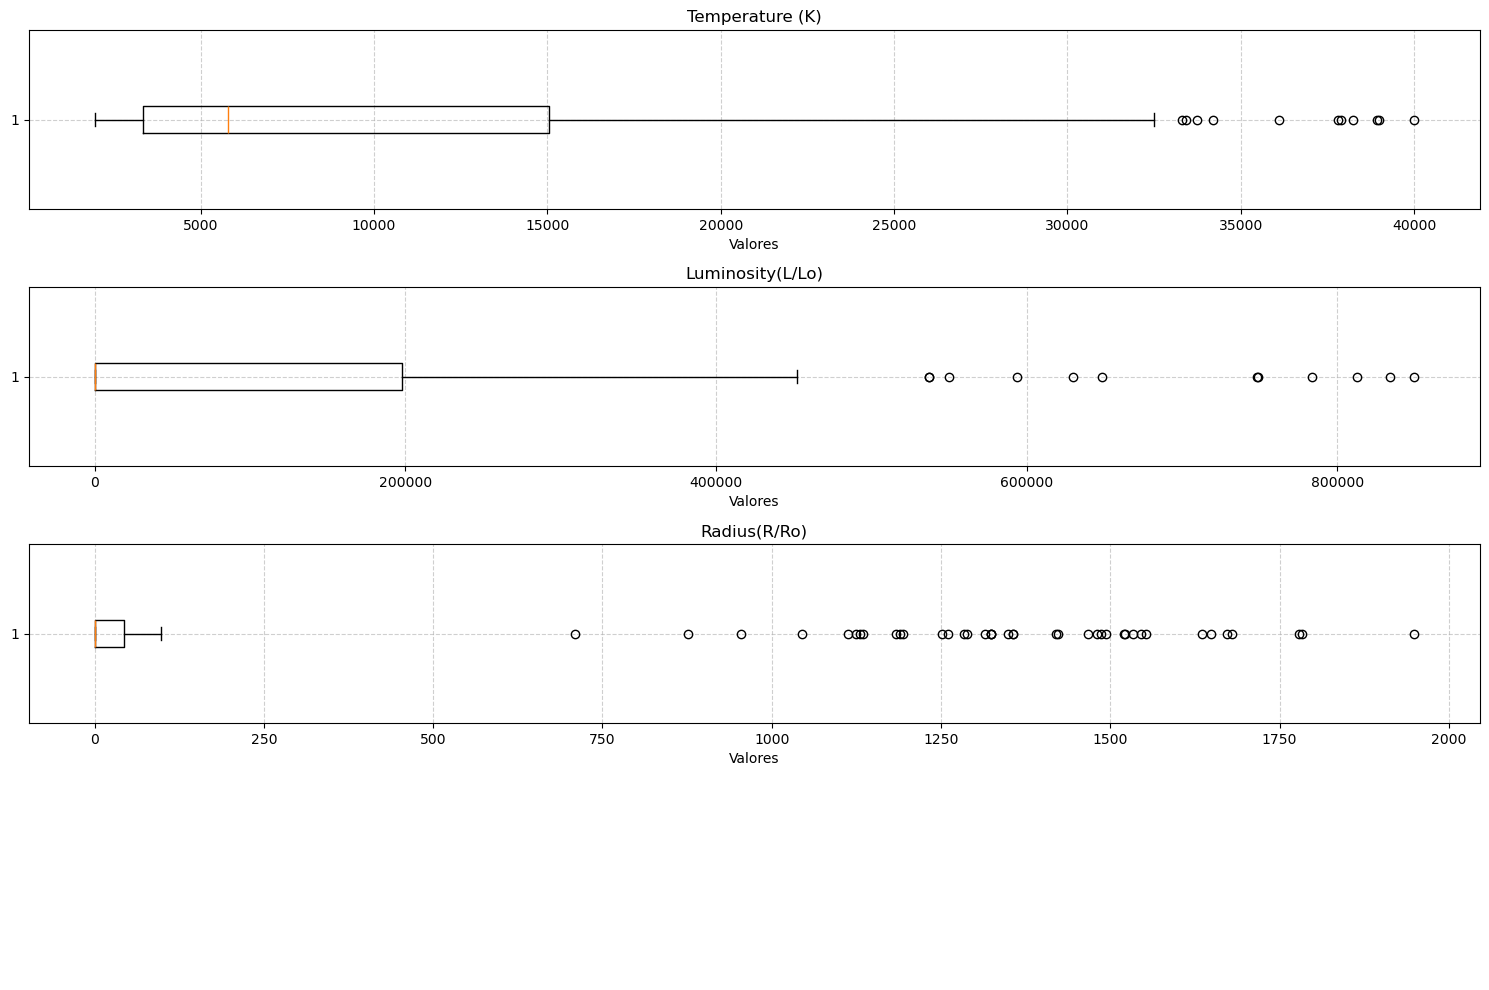

In [17]:
plot_outliers_boxplots(df, out_data)

Notas:  
- Como puede observarse tres features tienen valores outliers: Temperature, Luminosity y Radius.
- A simple vista se trata de pocos valores atípicos en cada una de las mediciones. 

# 4. Ingeniería de Características (Feature Engineering). 

### Transformación de variables categóricas a variables numéricas. 

In [18]:
def transform_categorical_to_numerical(all_data, column_name):
    """
    Mapea las ubicaciones de lluvia a números únicos.
    
    Args:
        all_data (DataFrame): DataFrame que contiene la columna de ubicaciones de lluvia.
        column_name (str): Nombre de la columna que contiene las ubicaciones de lluvia.
    
    Returns:
        DataFrame: DataFrame con la columna de ubicaciones mapeada a números.
    """
    all_ubications = all_data[column_name].unique()
    ubications_map = {}
    num = 1
    
    for ubication in all_ubications:
        ubications_map[ubication] = num
        num += 1

    print(f"Ubicaciones de lluvia mapeadas: {ubications_map}")

    # Mapeo de ubicaciones de lluvia a números
    all_data[column_name] = all_data[column_name].map(ubications_map)
    
    return all_data

In [19]:
df = transform_categorical_to_numerical(df, 'Star color')
df = transform_categorical_to_numerical(df, 'Spectral Class')


Ubicaciones de lluvia mapeadas: {'Red': 1, 'Blue White': 2, 'White': 3, 'Yellowish White': 4, 'Blue white': 5, 'Pale yellow orange': 6, 'Blue': 7, 'Blue-white': 8, 'Whitish': 9, 'yellow-white': 10, 'Orange': 11, 'White-Yellow': 12, 'white': 13, 'Blue ': 14, 'yellowish': 15, 'Yellowish': 16, 'Orange-Red': 17, 'Blue white ': 18, 'Blue-White': 19}
Ubicaciones de lluvia mapeadas: {'M': 1, 'B': 2, 'A': 3, 'F': 4, 'O': 5, 'K': 6, 'G': 7}


In [20]:
# Guardar el DataFrame limpio y preprocesado
df.to_csv('../data/processed/data_stars_processed.csv', index=False)

In [21]:
datau = pd.read_csv('../data/processed/data_stars_processed.csv')
data = datau.to_json(orient='records')
print(data)

[{"Temperature (K)":3068,"Luminosity(L\/Lo)":0.0024,"Radius(R\/Ro)":0.17,"Absolute magnitude(Mv)":16.12,"Star type":0,"Star color":1,"Spectral Class":1},{"Temperature (K)":3042,"Luminosity(L\/Lo)":0.0005,"Radius(R\/Ro)":0.1542,"Absolute magnitude(Mv)":16.6,"Star type":0,"Star color":1,"Spectral Class":1},{"Temperature (K)":2600,"Luminosity(L\/Lo)":0.0003,"Radius(R\/Ro)":0.102,"Absolute magnitude(Mv)":18.7,"Star type":0,"Star color":1,"Spectral Class":1},{"Temperature (K)":2800,"Luminosity(L\/Lo)":0.0002,"Radius(R\/Ro)":0.16,"Absolute magnitude(Mv)":16.65,"Star type":0,"Star color":1,"Spectral Class":1},{"Temperature (K)":1939,"Luminosity(L\/Lo)":0.000138,"Radius(R\/Ro)":0.103,"Absolute magnitude(Mv)":20.06,"Star type":0,"Star color":1,"Spectral Class":1},{"Temperature (K)":2840,"Luminosity(L\/Lo)":0.00065,"Radius(R\/Ro)":0.11,"Absolute magnitude(Mv)":16.98,"Star type":0,"Star color":1,"Spectral Class":1},{"Temperature (K)":2637,"Luminosity(L\/Lo)":0.00073,"Radius(R\/Ro)":0.127,"Absolut

# 5. EDA refinado y visualización. 

### Análisis Univariado. 

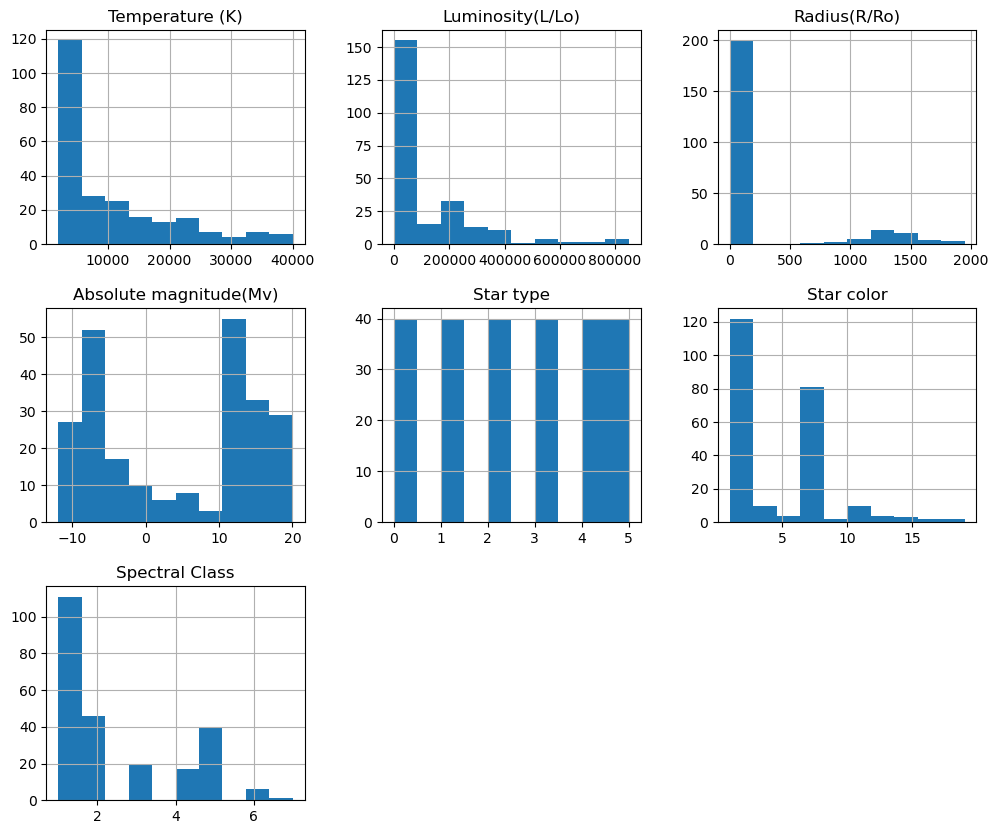

In [22]:
df.hist(figsize=(12,10))
plt.show()

### Análisis Bivariado.

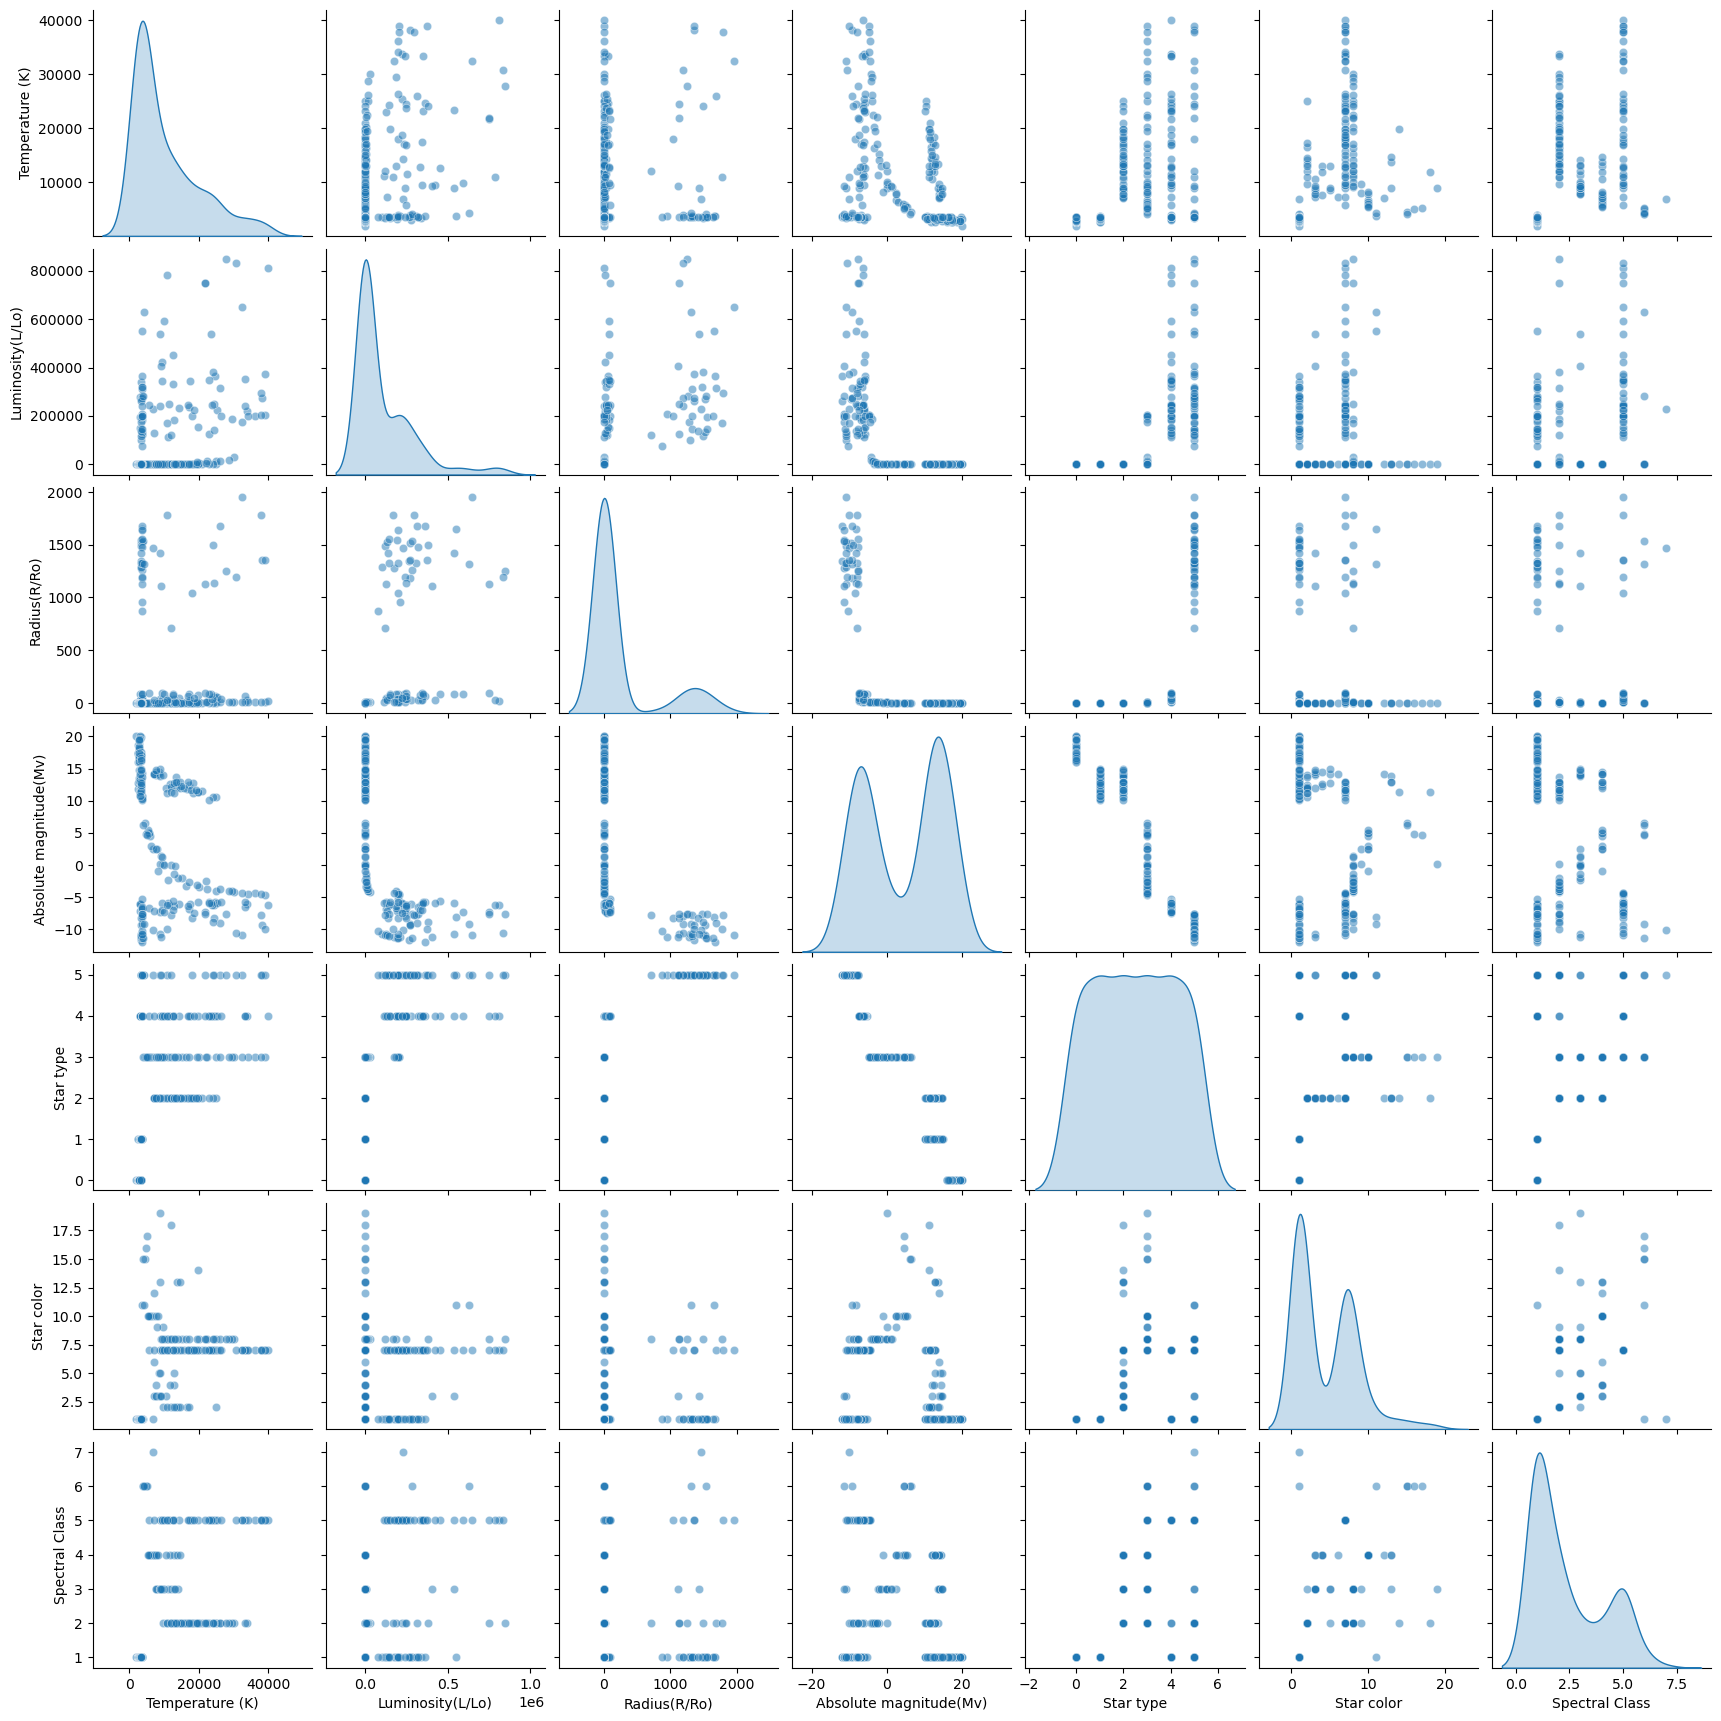

In [23]:
sns.pairplot(df, diag_kind='kde', markers='o', plot_kws={'alpha': 0.5})

### Corelación. 

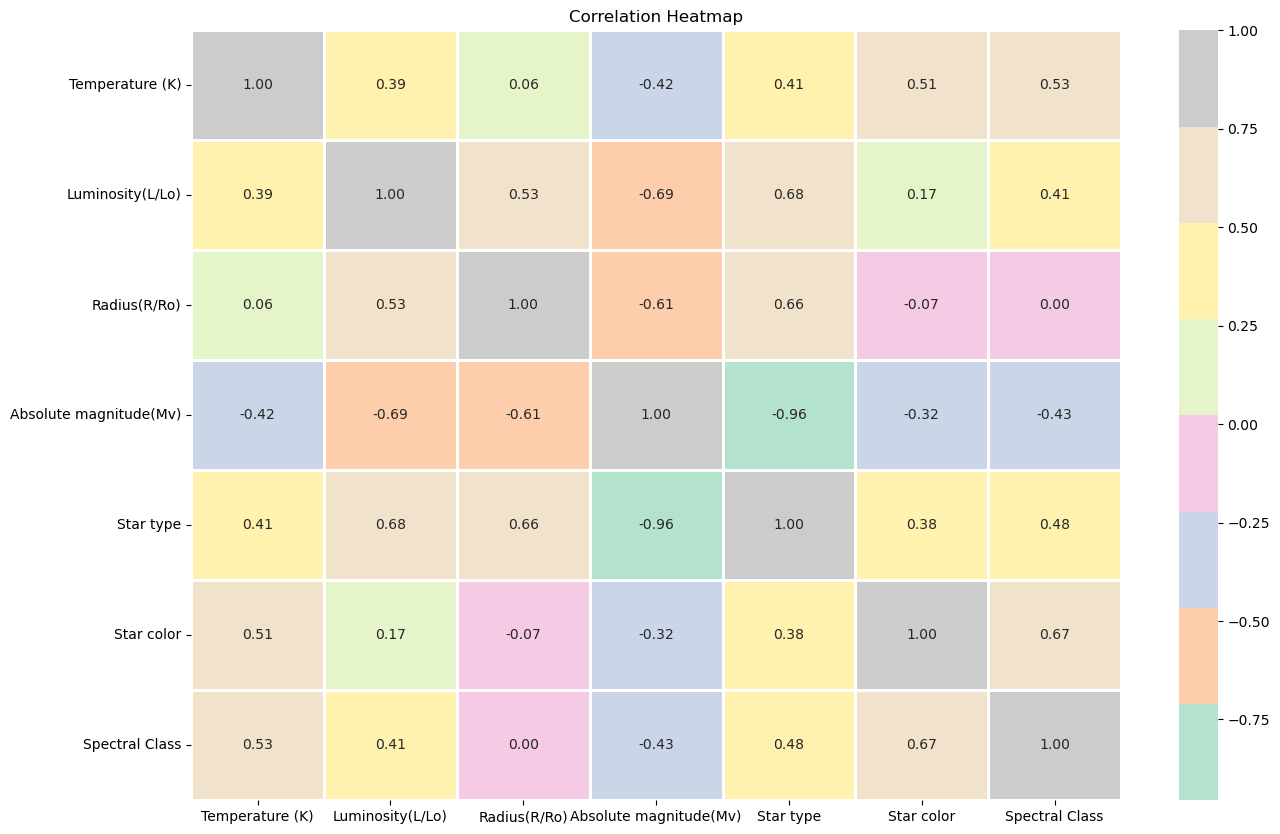

In [24]:
plt.figure(figsize=(15, 10))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='Pastel2', linewidths=2)

plt.title('Correlation Heatmap')
plt.show()

# 6. Modelo Predictivo. 

Exactitud del modelo Random Forest: 1.00

Reporte de Clasificación:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         6
           3       1.00      1.00      1.00         8
           4       1.00      1.00      1.00         8
           5       1.00      1.00      1.00        11

    accuracy                           1.00        48
   macro avg       1.00      1.00      1.00        48
weighted avg       1.00      1.00      1.00        48



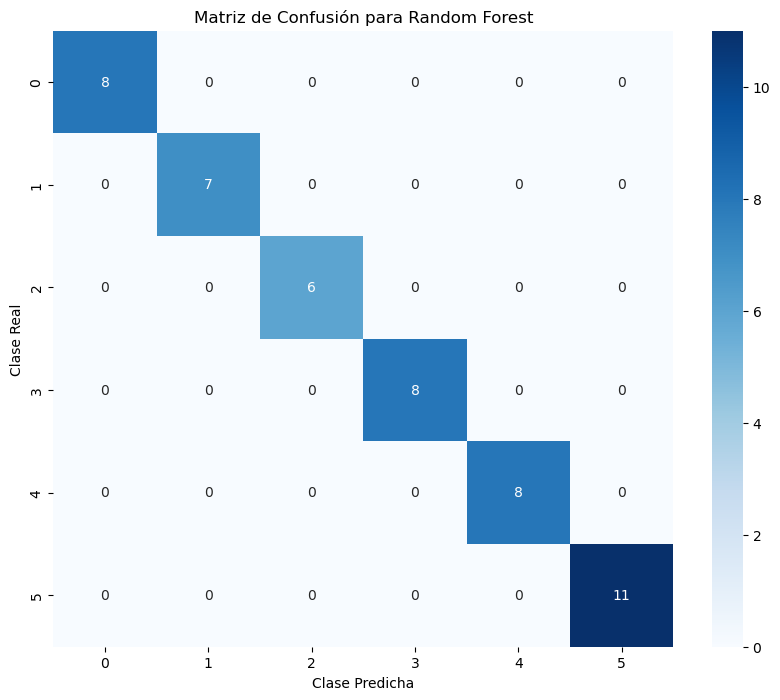

In [25]:

# 1. Preparación de los datos (simulando un conjunto de datos)
# En un escenario real, cargarías tu archivo con pd.read_csv('tu_archivo.csv')


# 2. Separar características (X) y la variable objetivo (y)
X = df.drop('Star type', axis=1)
y = df['Star type']

# 3. Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Entrenar el modelo de Random Forest
# n_estimators: número de árboles en el bosque
# random_state: para reproducibilidad
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=12,
    min_samples_split=10,
    min_samples_leaf=4,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# Entrenar el modelo con los datos de entrenamiento
rf_model.fit(X_train, y_train)

# 5. Realizar predicciones y evaluar el modelo
y_pred = rf_model.predict(X_test)

# Calcular la exactitud del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Exactitud del modelo Random Forest: {accuracy:.2f}\n")

# Mostrar el reporte de clasificación (precisión, recall, f1-score)
print("Reporte de Clasificación:\n", classification_report(y_test, y_pred))

# 6. Visualizar la Matriz de Confusión
# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Obtener las etiquetas de clase para los ejes
class_labels = np.unique(y)

# Crear la figura para la visualización
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title('Matriz de Confusión para Random Forest')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()

# 7. Optimización de Hiperparámetros. 

In [26]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define los pliegues para la validación cruzada estratificada
# Asegura que la proporción de clases se mantenga en cada pliegue
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define el modelo y el espacio de parámetros
rf_model = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5, 7],
    'class_weight': ['balanced', None]
}

# Usa GridSearchCV con la estrategia de validación estratificada
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=skf,  # <--- Usando StratifiedKFold aquí
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Ejecuta la búsqueda de hiperparámetros
grid_search.fit(X_train, y_train)

# Evalúa el mejor modelo
best_rf_model = grid_search.best_estimator_
y_pred = best_rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         6
           3       1.00      1.00      1.00         8
           4       1.00      1.00      1.00         8
           5       1.00      1.00      1.00        11

    accuracy                           1.00        48
   macro avg       1.00      1.00      1.00        48
weighted avg       1.00      1.00      1.00        48



In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Definimos el modelo base
rf_model = RandomForestClassifier(
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# Espacio de búsqueda de hiperparámetros
param_dist = {
    "n_estimators": randint(100, 500),        # número de árboles
    "max_depth": randint(5, 30),              # profundidad máxima
    "min_samples_split": randint(2, 20),      # mínimo de muestras para dividir
    "min_samples_leaf": randint(1, 10),       # mínimo de muestras en una hoja
    "max_features": ["sqrt", "log2", None]    # selección de features
}

# Configuración de la búsqueda aleatoria
random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=50,               # número de combinaciones a probar
    cv=5,                    # validación cruzada 5 folds
    scoring='f1_macro',      # métrica (puedes usar 'accuracy', 'roc_auc', etc.)
    random_state=42,
    n_jobs=-1,
    verbose=2
)

# Entrenamos con la búsqueda
random_search.fit(X_train, y_train)

# Mejor modelo encontrado
print("Mejores hiperparámetros:", random_search.best_params_)
print("Mejor score CV:", random_search.best_score_)

# Predicciones en test
best_model = random_search.best_estimator_
y_pred_f = best_model.predict(X_test)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END max_depth=11, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=221; total time=   0.3s
[CV] END max_depth=11, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=221; total time=   0.3s
[CV] END max_depth=11, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=221; total time=   0.3s
[CV] END max_depth=11, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=221; total time=   0.3s
[CV] END max_depth=11, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=221; total time=   0.3s
[CV] END max_depth=23, max_features=None, min_samples_leaf=8, min_samples_split=5, n_estimators=459; total time=   0.5s
[CV] END max_depth=23, max_features=None, min_samples_leaf=8, min_samples_split=5, n_estimators=459; total time=   0.6s
[CV] END max_depth=23, max_features=None, min_samples_leaf=8, min_samples_split=5, n_estimators=45

In [28]:
print(classification_report(y_test, y_pred_f))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         6
           3       1.00      1.00      1.00         8
           4       1.00      1.00      1.00         8
           5       1.00      1.00      1.00        11

    accuracy                           1.00        48
   macro avg       1.00      1.00      1.00        48
weighted avg       1.00      1.00      1.00        48



# 8. Guardar modelo. 

In [29]:
# --- Guardar el modelo ---
filename = '../models/star_prediction_model.pkl'

# Guarda el modelo en el archivo
joblib.dump(best_model, filename)

print(f"El modelo ha sido guardado en el archivo: {filename}")

El modelo ha sido guardado en el archivo: ../models/star_prediction_model.pkl
